 <img src="https://challengepost-s3-challengepost.netdna-ssl.com/photos/production/challenge_thumbnails/000/956/166/datas/original.png" width=100 align="right">
 <div style="font-size: large;"><b>Group Work</b> - Recommender Systems</div><br>
 <br>
 <br>
 <b>Group F</b><br>
 <br>
 <a href="mailto:alhagbani@student.ie.edu">Abdulaziz Alhagbani</a><br>
 <a href="mailto:juanbretti@student.ie.edu">Juan Pedro Bretti Mandarano</a><br>
 <a href="mailto:alexander.madzhirov@student.ie.edu">Aleksandar Madzhirov</a><br>
 <a href="mailto:esperanza.magpantay@student.ie.edu">Esperanza Magpantay</a><br>
 <a href="mailto:addison.pelayo@student.ie.edu">Addison Pelayo</a><br>
 <br>
 Delivery: NOV/2020<br>
 <br>
 <a href="https://www.ie.edu/school-human-sciences-technology/masters/global-master-business-analytics-big-data/">Global Master in Business Analytics and Big Data</a> | <a href="https://www.ie.edu/">IE</a>

# Required libraries ----
 Loading necessary Python libraries.
 For this particular exercise, we are using [Surprise](https://github.com/NicolasHug/Surprise).Surprise is a Python SciKit that comes with various recommender algorithms and similarity metrics to make it easy to build and analyze recommenders.<br>

In [2]:
import pandas as pd
import gzip

# Report
from pandas_profiling import ProfileReport

# Plots
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, plot, iplot
import plotly.graph_objs as go

# Pre processing
import numpy as np
from sklearn.model_selection import train_test_split

# Collaborative Filtering
from surprise import Dataset
from surprise import Reader
from surprise import KNNBaseline
from surprise import PredictionImpossible
from surprise import AlgoBase
from surprise import SVD, BaselineOnly, NMF, SlopeOne, CoClustering, SVDpp, NormalPredictor
from surprise.model_selection import cross_validate
from surprise.model_selection.search import GridSearchCV

# Import wordcloud library
from wordcloud import WordCloud

# Load the library with the CountVectorizer method
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# Cosine
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Performance
from sklearn.metrics import mean_squared_error


# Reading the data ----
 Source: http://jmcauley.ucsd.edu/data/amazon/ <br>
 In particular, we are using the dataset `reviews_Patio_Lawn_and_Garden_5`, which contains 13,272 reviews.<br>
 The selection of the dataset, was based on CPU time.

In [3]:
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)

def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

df = getDF('raw/reviews_Patio_Lawn_and_Garden_5.json.gz')


# EDA ----
 The following is an `HTML` report of the data.<br>
 Also, printing a few lines of the dataset inline in this notebook.

## HTML report ----

In [4]:
# The following lines are disable to speed up.
# The `html` output is generated already and shared with this assignment.
profile = ProfileReport(df, title="Patio_Lawn_and_Garden", minimal=False)
profile.to_file("storage/df_report.html")


Export report to file: 100%|██████████| 1/1 [00:00<00:00, 252.62it/s]


## Few rows ----

In [5]:
print('Dataset shape: {}'.format(df.shape))
print('-Dataset row examples-')
print(df.iloc[::20000, :])


Dataset shape: (13272, 9)
-Dataset row examples-
       reviewerID        asin                            reviewerName helpful  \
0  A1JZFGZEZVWQPY  B00002N674  Carter H "1amazonreviewer@gmail . com"  [4, 4]   

                                          reviewText  overall      summary  \
0  Good USA company that stands behind their prod...      4.0  Great Hoses   

   unixReviewTime   reviewTime  
0      1308614400  06 21, 2011  


## Plots ----
### Ratings distribution
 The first thing is to analyze the distribution of ratings to understand among other things:
 - The rating scale: goes from 1 to 5
 - The distribution of the ratings: are the users biased to high or low rates?
 - Are the users using the entire rating scale? e.g.: sometimes people performs binary ratings even if you provide them with a more granular scale (5 good, 1 bad and nothing in between)

In [6]:
init_notebook_mode(connected=True)

# Count the number of times each rating appears in the dataset
data = df['overall'].value_counts().sort_index(ascending=False)

# Create the histogram
trace = go.Bar(x = data.index,
               text = ['{:.1f} %'.format(val) for val in (data.values / df.shape[0] * 100)],
               textposition = 'auto',
               textfont = dict(color = '#000000'),
               y = data.values,
               )
# Create layout
layout = dict(title = 'Distribution Of {} Ratings'.format(df.shape[0]),
              xaxis = dict(title = 'Rating'),
              yaxis = dict(title = 'Count'))
# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


 We can see the distribution of the ratings is skewed to the high values.
## Numbers of ratings per item ----
 The following analysis checks how many ratings (interactions) each item has.<br>
 The degree in which this long tail phenomena occurs will be related to aspects such as serendipity or overespecialization of the recommendations and the recommendation methodology that you should select.

In [7]:

# Number of ratings per item
data = df.groupby('asin')['overall'].count()

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0,size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per Product Id',
                   xaxis = dict(title = 'Number of Ratings Per Product Id'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


## Number of ratings per user ----
 Now it's time to see how many ratings we have per user.

In [8]:
# Number of ratings per user
data = df.groupby('reviewerID')['overall'].count()

# Create trace
trace = go.Histogram(x = data.values,
                     name = 'Ratings',
                     xbins = dict(start = 0, size = 2))
# Create layout
layout = go.Layout(title = 'Distribution Of Number of Ratings Per User',
                   xaxis = dict(title = 'Ratings Per User'),
                   yaxis = dict(title = 'Count'),
                   bargap = 0.2)

# Create plot
fig = go.Figure(data=[trace], layout=layout)
iplot(fig)


 As expected similar distribution as per item.

# Managing data with Surprise ----
 It's now time to convert our datasets to the format required by the Surprise library.<br>
 To load a data set from the above pandas data frame, we will use the *load_from_df()* method, we will also need a Reader object, and the rating_scale parameter must be specified. The data frame must have three columns, corresponding to the user ids, the item ids, and the ratings in this order. Each row thus corresponds to a given rating.<br>

# Split the dataset ----
## Data selection and preprocessing
 Created a training dataset and a testing dataset from therein for the experiment. <br>
 A recommended standard pre-processing strategy is that: for each user, randomly select 80% of ratings as the training ratings and use the remaining 20% ratings as testing ratings.<br>
 We use the `scikit-learn` library for helping the stratification per user.

In [9]:
data_train, data_test = train_test_split(df, test_size=0.20, random_state=42, stratify=df['reviewerID'])
# Clear index for future usage
data_train.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)


In [10]:
## Collaborative Filtering ----
# Convert the `Pandas` into a `surprise` dataset format.


In [11]:
reader = Reader(rating_scale=(1, 5))
data_train_cf = Dataset.load_from_df(data_train[['reviewerID', 'asin', 'overall']], reader)
data_test_cf = Dataset.load_from_df(data_test[['reviewerID', 'asin', 'overall']], reader)


## Neighbourhood-based ----
 Collaborative filtering.<br>
 <br>
 We are going to start by using one of the simplest recommendation methodologies (Neighbourhood-based CF). This technique is pretty simple and fast, but it provides accurate results for many scenarios.<br>
 To specify the parameters of the execution, we simply configure the function by passing a dictionary as an argument to the recommender function. The dictionary should have the required keys, such as the following:
 - **name** contains the similarity metric to use. Options are cosine, msd, pearson, or pearson_baseline. The default is msd.
 - **user_based** is a boolean that tells whether the approach will be user-based or item-based. The default is True, which means the user-based approach will be used.
 - **min_support** is the minimum number of common items needed between users to consider them for similarity. For the item-based approach, this corresponds to the minimum number of common users for two items.
 In particular, I will use the cosine distance as similarity metric for finding the neighbors, using the item-based approach

In [12]:
# To use item-based cosine similarity
sim_options = {
    "name": "cosine",
    "user_based": False # Compute  similarities between items
}
knn = KNNBaseline(sim_options=sim_options)

results = cross_validate(knn, data_train_cf, measures=['RMSE'], cv=3, verbose=True, n_jobs=-1)


Evaluating RMSE of algorithm KNNBaseline on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0809  1.0762  1.0701  1.0757  0.0044  
Fit time          0.05    0.05    0.05    0.05    0.00    
Test time         0.05    0.05    0.04    0.05    0.00    


## Group algorithm ----
 As reference, the following were used for the development of our group algorithm.<br>
 https://surprise.readthedocs.io/en/stable/building_custom_algo.html?highlight=fit#the-fit-method<br>
 https://github.com/NicolasHug/Surprise/blob/fa7455880192383f01475162b4cbd310d91d29ca/examples/building_custom_algorithms/with_baselines_or_sim.py

In [13]:
class GroupAlgorithm(AlgoBase):

    def __init__(self, sim_options={}, bsl_options={}):

        AlgoBase.__init__(self, sim_options=sim_options, bsl_options=bsl_options)

    def fit(self, trainset):

        AlgoBase.fit(self, trainset)

        # Compute baselines and similarities
        self.bu, self.bi = self.compute_baselines()
        self.sim = self.compute_similarities()

        return self

    def estimate(self, u, i):

        if not (self.trainset.knows_user(u) and self.trainset.knows_item(i)):
            raise PredictionImpossible('User and/or item is unknown.')

        # Compute similarities between u and v, where v describes all other users that have also rated item i.
        neighbors = [(v, self.sim[u, v]) for (v, r) in self.trainset.ir[i]]
        # Sort these neighbors by similarity
        neighbors = sorted(neighbors, key=lambda x: x[1], reverse=True)

        print('The 4 nearest neighbors of user', str(u), 'are:')
        for v, sim_uv in neighbors[:4]:
            print('user {0:} with sim {1:1.2f}'.format(v, sim_uv))

        # Return the baseline estimate
        bsl = self.trainset.global_mean + self.bu[u] + self.bi[i]
        return bsl


## Benchmarking ----
 In the following exercise we are going to experiment with different algorithms to check which one of them offers the best results.<br>
 This algorithms are expensive in computing process. There are some GPU-enabled alternatives but we preferred to try simpler implementations first.

In [14]:
benchmark = []
# Iterate over all algorithms
for algorithm in [SVD(), SVDpp(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), BaselineOnly(), CoClustering(), GroupAlgorithm()]:
    
    print("Testing {}".format(algorithm))
    # Perform cross validation
    results = cross_validate(algorithm, data_train_cf, measures=['RMSE'], cv=3, verbose=False, n_jobs=-1)
    
    # Get results & append algorithm name
    tmp = pd.DataFrame.from_dict(results).mean(axis=0)
    tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
    benchmark.append(tmp)
    
pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')    


Testing <surprise.prediction_algorithms.matrix_factorization.SVD object at 0x000001E838C81B80>
Testing <surprise.prediction_algorithms.matrix_factorization.SVDpp object at 0x000001E838C816A0>
Testing <surprise.prediction_algorithms.slope_one.SlopeOne object at 0x000001E838B04370>
Testing <surprise.prediction_algorithms.matrix_factorization.NMF object at 0x000001E838B04490>
Testing <surprise.prediction_algorithms.random_pred.NormalPredictor object at 0x000001E838B042E0>
Testing <surprise.prediction_algorithms.knns.KNNBaseline object at 0x000001E838B043A0>
Testing <surprise.prediction_algorithms.baseline_only.BaselineOnly object at 0x000001E838B044C0>
Testing <surprise.prediction_algorithms.co_clustering.CoClustering object at 0x000001E838B04460>
Testing <__main__.GroupAlgorithm object at 0x000001E838B04A30>


,test_rmse,fit_time,test_time
Algorithm,,,
SVDpp,0.994173,0.938822,0.052527
SVD,0.999558,0.345408,0.019947
GroupAlgorithm,0.999839,0.055185,1.634961
BaselineOnly,1.002738,0.005652,0.010998
KNNBaseline,1.079227,0.054498,0.078789
CoClustering,1.114274,0.288873,0.014960
SlopeOne,1.186141,0.027261,0.022606
NMF,1.240939,0.433175,0.016290
NormalPredictor,1.399122,0.006992,0.015645


## Hyperparameter optimization ----
 We had selected as best performant the `svd++` algorithms. It must be considered that the selected method has the highest CPU time, but we are using a small dataset to overcame the limitations. Also we are using a 16 cores CPU to speed up the training and following processes.

In [15]:
# https://towardsdatascience.com/svd-where-model-tuning-goes-wrong-61c269402919
# https://surprise.readthedocs.io/en/stable/matrix_factorization.html?highlight=SVDpp#surprise.prediction_algorithms.matrix_factorization.SVDpp
param_grid = {'n_factors':[50,100,150], 'n_epochs':[20,30], 'lr_all':[0.005,0.01,0.007], 'reg_all':[0.02,0.1]}
gs = GridSearchCV(SVDpp, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(data_train_cf)

# best RMSE score
print(gs.best_score['rmse'])
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


0.9950887601170791
{'n_factors': 50, 'n_epochs': 30, 'lr_all': 0.005, 'reg_all': 0.1}


 Using the `test` dataset to evaluate the final performance of the model

In [16]:
svdpp_tuned = SVDpp(**gs.best_params['rmse'], random_state=42)


In [17]:
#### Train ----
cross_validate(svdpp_tuned, data_train_cf, measures=['RMSE'], cv=3, verbose=True, n_jobs=-1)


Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9820  1.0077  0.9904  0.9933  0.0107  
Fit time          2.26    2.35    2.29    2.30    0.04    
Test time         0.06    0.05    0.06    0.05    0.00    


{'test_rmse': array([0.98203354, 1.00765307, 0.99036279]),
 'fit_time': (2.2648913860321045, 2.3520078659057617, 2.288012981414795),
 'test_time': (0.05706191062927246, 0.05104970932006836, 0.055048227310180664)}

In [18]:
#### Test ----
cross_validate(svdpp_tuned, data_test_cf, measures=['RMSE'], cv=3, verbose=True, n_jobs=-1)


Evaluating RMSE of algorithm SVDpp on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.0633  1.0778  1.0137  1.0516  0.0274  
Fit time          0.35    0.34    0.34    0.34    0.00    
Test time         0.01    0.01    0.01    0.01    0.00    


{'test_rmse': array([1.06329261, 1.07778687, 1.01372109]),
 'fit_time': (0.34510254859924316, 0.34410548210144043, 0.3431119918823242),
 'test_time': (0.007994651794433594,
  0.007994651794433594,
  0.00797581672668457)}

 It can be noticed a small `overfitting` from our model. But it's reasonable considering the small size of the data set and the small grid space for the `grid search`.

# Content-Based recommendation----
 System using TFIDF with recommendations per user and metrics on results
## Exploratory Analysis ----
 To verify whether the preprocessing happened correctly, we’ll make a word cloud using the wordcloud package to get a visual representation of most common words. It is key to understanding the data and ensuring we are on the right track, and if any more preprocessing is necessary before training the model.

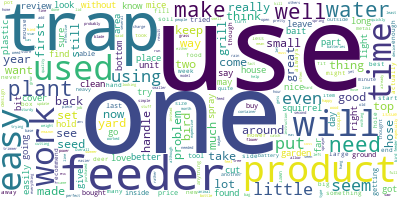

In [19]:
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

# Join the different processed titles together.
long_string = ','.join(list(df['reviewText'].values))
# Create a WordCloud object
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')
# Generate a word cloud
wordcloud.generate(long_string)
# Visualize the word cloud
wordcloud.to_image()


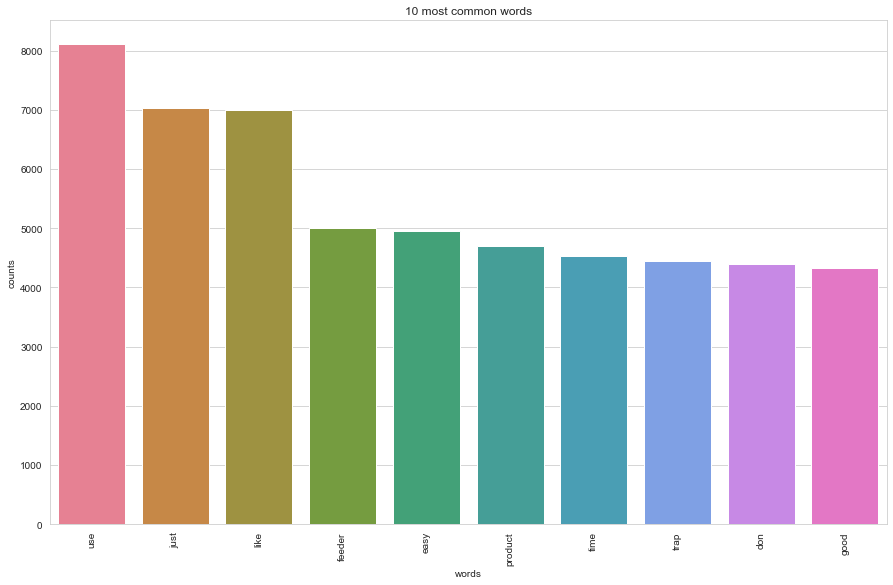

In [20]:
# Helper function
def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
# Initialise the count vectorizer with the English stop words
count_vectorizer = CountVectorizer(stop_words='english')
# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df['reviewText'])
# Visualize the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)


## Cosine similarity ----
 Following, we are creating a personalized `content-based recommender system`.<br>
 In particular, we are using a pipeline that converts the `reviews` into a matrix using `TF-IDF`.<br>
 Then we calculate each vector distance to the other reviews, using a `linear_kernel`.

In [21]:
def cosine_distance(data):
    """After a `vector`, it calculates the cosine distance of each row/column.

    Args:
        data (Vector): Vector or strings

    Returns:
        [matrix]: Square matrix with the distances
    """
    #Construct the required TF-IDF matrix by fitting and transforming the data
    vectorizer = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english', token_pattern=r'(?u)\b[A-Za-z]+\b')
    vectorizer = vectorizer.fit(data)  
    tfidf_matrix = vectorizer.transform(data)
    # Calculate the distances
    return linear_kernel(tfidf_matrix, tfidf_matrix)


## Get recommendations ----
 The following is an **ad-hoc** function to calculate a distance between the reference review (`reviewerID_base`) and the rest of the available ones.<br>
 This implementation could be improved by tunning the -now fixed- `recomm_threshold`. This are the thresholds to define at which distance between reviews the rating should be 1 to 5.
 Also inside this function, is calculated the `RMSE` using a `data_test`.

In [22]:
def get_recommendation_content_model(reviewerID_base, data_train, data_train_cosine, data_test=None):
    """Calculates a `DataFrame` with the distance from the `reviewerID_base` and the `data_train`.

    Args:
        reviewerID_base ([string]): Customer ID from Amazon
        data_train ([DataFrame]): DataFrame in the original format, for the training.
        data_train_cosine ([matrix]): Matrix with the distances between reviews
        data_test ([DataFrame], optional): DataFrame in the original format, for the test set. This will not be used for training. Defaults to None.

    Returns:
        [DataFrame, float]: The original dataframe, with the addition of the `predicted rating`. Also the RMSE.
    """
    ## Train
    # Parameter definition
    recomm_threshold = [0, 0.02/32, 0.02/16, 0.02/4, 0.02, 1] # Needs optimization, values in ascending order [0, 1]

    # Data from the current reviewer
    data_distance_reviewer = data_train[data_train['reviewerID']==reviewerID_base]
    # The `asin` that `reviewerID_base` likes the most
    asin_base = data_distance_reviewer[data_distance_reviewer['overall']==data_distance_reviewer['overall'].max()]['asin']

    # All the reviews for the `asin` required
    idx_item = data_train.loc[data_train['asin'].isin(asin_base)].index
    # Convert to `pd.DataFrame`
    cb_distance = pd.DataFrame(data_train_cosine[idx_item], columns=data_train['asin'])
    # Melt the DataFrame, group by `asin`, calculate mean distance, and sort
    cb_distance = pd.melt(cb_distance).groupby('asin', as_index=False).agg('mean').sort_values(by='value', ascending=False)
    # Apply rating
    cb_distance['Rating'] = pd.cut(x=cb_distance['value'], bins=recomm_threshold, labels=[1,2,3,4,5])

    ## Test
    if data_test is not None:
        data_test_reviewer = data_test[data_test['reviewerID']==reviewerID_base]
        cb_merged = data_test_reviewer.merge(cb_distance, on='asin', how='left')
        # RMSE
        RMSE = mean_squared_error(cb_merged['overall'], cb_merged['Rating'], squared=False)
    else:
        RMSE = None

    return cb_distance, RMSE


### Testing with one `reviewerID` ----
 For code debuging and testing of the previously defined methodology, a one customer test is being done. Using `reviewerID_base` = `A2VYA302TO2K1C`.<br>
 Also the `cosine_distance` is being calculated. This is a CPU intensive operation.

In [23]:
data_train_cosine = cosine_distance(data_train['reviewText'])

reviewerID_base = 'A2VYA302TO2K1C'
recommendations = get_recommendation_content_model(reviewerID_base, data_train, data_train_cosine, data_test)


## Performance benchmark ----
 Execution of the `content-based recommender system` for the first 10 **reviewers**. <br>
 The number of **reviewers** can be controlled by changing `first_reviewers`

In [24]:
# Limited to the first `10`, for speeding considerations
first_reviewers = 10

performance_ = []
for reviewerID_base in data_test['reviewerID'].unique()[:first_reviewers]:
    recommended_by_cb = get_recommendation_content_model(reviewerID_base, data_train, data_train_cosine, data_test)
    recommended_by_cb = recommended_by_cb[1]
    performance_.append(recommended_by_cb)

print(f'RMSE of the content-based recommender system is {np.mean(performance_).round(2)}.')


RMSE of the content-based recommender system is 0.67.


# Hybrid model ----
 This model is the combination of the `collaborative filtering` and the `content-based` recommender system.
## Function definition ----

In [25]:
def hybrid_content_svdpp_per_reviewer(reviewerID_base, data_train, data_train_cosine, data_test, svdpp_tuned):
    """Hybrid monolithic recommender system. The combination of the `collaborative filtering` and the `content-based` recommender system.

    Args:
        reviewerID_base ([str]): Customer ID from Amazon
        data_train ([DataFrame]): DataFrame in the original format, for the training.
        data_train_cosine ([Matrix]): Matrix with the distances between reviews
        data_test ([DataFrame]): DataFrame in the original format, for the test set. This will not be used for training.
        svdpp_tuned ([surprise model]): SVD++ model tuned and fitted to the train data

    Returns:
        [vector, RMSE]: List of recommendations and RMSE using the test set only
    """
    recommendations_ = []
    recommended_by_cb = get_recommendation_content_model(reviewerID_base, data_train, data_train_cosine, data_test)

    for _, row in recommended_by_cb[0].iterrows():
        predict = svdpp_tuned.predict(reviewerID_base, row['asin'])
        recommendations_.append([reviewerID_base, row['asin'], predict.est])
    recommendations_ = pd.DataFrame(recommendations_, columns=['reviewerID', 'asin', 'predict'])
    recommendations_ = recommendations_.sort_values(by='predict', ascending=False)
    return recommendations_, recommended_by_cb[1]


### Testing with one `reviewerID` ----
 SVD++ model fitted to the trainset.<br>
 As before we are testing one single `reviewerID` for debug prepuse.

In [26]:
# https://surprise.readthedocs.io/en/stable/getting_started.html#train-on-a-whole-trainset-and-the-predict-method
trainset = data_train_cf.build_full_trainset()
svdpp_tuned.fit(trainset)

reviewerID_base='A6HOWM08PLFZ5'
hybrid_content_svdpp_per_reviewer(reviewerID_base, data_train, data_train_cosine, data_test, svdpp_tuned)


(        reviewerID        asin   predict
 155  A6HOWM08PLFZ5  B00FZJ9FXE  5.000000
 908  A6HOWM08PLFZ5  B001AN7RGG  5.000000
 783  A6HOWM08PLFZ5  B000FJYSHW  5.000000
 747  A6HOWM08PLFZ5  B0012QLVRM  4.979889
 427  A6HOWM08PLFZ5  B0071E238A  4.977554
 ..             ...         ...       ...
 900  A6HOWM08PLFZ5  B000094YKM  3.278788
 60   A6HOWM08PLFZ5  B00AQ4BYBO  3.209126
 179  A6HOWM08PLFZ5  B001P82AHW  3.103981
 158  A6HOWM08PLFZ5  B00G8R2RPK  2.861056
 270  A6HOWM08PLFZ5  B009QARRP6  2.845861
 
 [962 rows x 3 columns],
 1.0)

# Test ----
## Apply to all the reviewer ----
 For computing time considerations, we are allowing to limit the number of reviewers by changing `first_reviewers`.<br>
 Also we are limiting the number of recommendations per Amazon user by changing `top_n`.

In [27]:
first_reviewers = 1686
top_n = 5

recommendations_collector = pd.DataFrame()
performance_collector = []

for reviewerID_base in data_test['reviewerID'].unique()[:first_reviewers]:
    recommendations_, performance_ = hybrid_content_svdpp_per_reviewer(reviewerID_base, data_train, data_train_cosine, data_test, svdpp_tuned)
    recommendations_collector = recommendations_collector.append(recommendations_.head(top_n))
    performance_collector.append(performance_)

In [28]:
recommendations_collector.head(20)


,reviewerID,asin,predict
155,A6HOWM08PLFZ5,B00FZJ9FXE,5.000000
908,A6HOWM08PLFZ5,B001AN7RGG,5.000000
783,A6HOWM08PLFZ5,B000FJYSHW,5.000000
747,A6HOWM08PLFZ5,B0012QLVRM,4.979889
427,A6HOWM08PLFZ5,B0071E238A,4.977554
417,A3L20U76EG3KP4,B000WEOQV8,4.968442
871,A3L20U76EG3KP4,B000NCWP44,4.880817
547,A3L20U76EG3KP4,B001AN7RGG,4.872792
786,A3L20U76EG3KP4,B00D2VUOU0,4.844005
234,A3L20U76EG3KP4,B00004U9VV,4.842439


 Performance of the hybrid model.<br>
 The RMSE has not been improved, but we are providing to the customer with products with more **serendipity** (outside of the current specialization).

In [29]:
print(f'RMSE of the hybrid monolithic recommender system is {np.mean(performance_collector).round(2)}.')


RMSE of the hybrid monolithic recommender system is 1.27.
